In [ ]:
import tensorflow as tf
import numpy as np
import keras
from keras import applications, utils, layers ,callbacks 


gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Set memory growth for each GPU to true
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)



def mixup_data(x, y, alpha):
 
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1.0

    batch_size = tf.shape(x)[0]
    # Shuffle the batch indices
    indices = tf.random.shuffle(tf.range(batch_size))
    x_shuffled = tf.gather(x, indices)
    y_shuffled = tf.gather(y, indices)
    
    # Create mixed inputs and targets
    x_mix = lam * x + (1 - lam) * x_shuffled
    y_mix = lam * y + (1 - lam) * y_shuffled
    return x_mix, y_mix, lam


def mixup_generator(x, y, batch_size, alpha):
    
    num_samples = x.shape[0]
    indices = np.arange(num_samples)
    while True:
        np.random.shuffle(indices)
        for i in range(0, num_samples, batch_size):
            batch_indices = indices[i:i+batch_size]
            x_batch = x[batch_indices]
            y_batch = y[batch_indices]
            x_mix, y_mix, _ = mixup_data(x_batch, y_batch, alpha)
            yield x_mix, y_mix

# Load CIFAR-100 data
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar100.load_data(label_mode="fine")

# For ResNet preprocessing, images are expected in range [0, 255]
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

# ResNet-specific preprocessing
x_train = applications.resnet.preprocess_input(x_train)
x_test = applications.resnet.preprocess_input(x_test)

# Convert labels to one-hot encoding
y_train = utils.to_categorical(y_train, 100)
y_test = utils.to_categorical(y_test, 100)

2025-03-30 05:51:52.628738: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-30 05:51:52.813378: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1743310312.889764   82930 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1743310312.912625   82930 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-30 05:51:53.098580: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

1 Physical GPUs, 1 Logical GPUs


In [ ]:
from sklearn.model_selection import train_test_split

# Define the validation split ratio
val_size = 0.2
# Split the test set into validation and new test sets
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=val_size, random_state=42)

# Print the new dataset shapes
print(f"New Train Set Shape: {x_train.shape}, {y_train.shape}")
print(f"Validation Set Shape: {x_val.shape}, {y_val.shape}")

New Train Set Shape: (40000, 32, 32, 3), (40000, 100)
Validation Set Shape: (10000, 32, 32, 3), (10000, 100)


In [ ]:
# Define parameters
batch_size = 128
alpha = 0.3 # Augmenation intensity
steps_per_epoch = x_train.shape[0] // batch_size

# Create the mixup generator
train_gen = mixup_generator(x_train, y_train, batch_size, alpha)

In [ ]:
# Build simple ResNet50 model 
base_model = applications.ResNet50(
    input_shape=(224,224, 3), weights="imagenet", include_top= False #pooling doesn't work
)

base_model.trainable= False  

model = keras.Sequential(
    [
        keras.Input(shape=[32,32,3], batch_size= batch_size),
        layers.Resizing(224,224,interpolation='bilinear'), #bicubic doesn't work
        base_model,
        layers.GlobalAveragePooling2D(),
        #layers.Flatten(),
        layers.Dense(1900, activation ='tanh', name= 'Dense1'),
        #layers.Dropout(0.5),
        layers.Dense(1600, activation='tanh', name='Dense2'),
        #layers.Dropout(0.3),
        #layers.Dense(256, activation='relu', name='Dense2'),
        #layers.Dropout(0.1), #vary the dropout
        layers.Dense(100, activation='softmax', name='output')
    ]
)



model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

model.summary()
#model.summary(expand_nested=True,show_trainable=True)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resizing (Resizing)             │ (128, 224, 224, 3)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (128, 7, 7, 2048)      │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (128, 2048)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense1 (Dense)                  │ (128, 1900)            │     3,893,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense2 (Dense)                  │ (128, 1600)            │     3,041,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (128, 100)             │       160,100 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,682,512 (117.04 MB)

 Trainable params: 7,094,800 (27.06 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [ ]:
reduce_lr = callbacks.ReduceLROnPlateau(
    monitor='val_accuracy', 
    factor=0.7,
    patience=5,
    verbose=1,
    mode='max',
    min_lr=0.00000001
)

early_stopping =callbacks.EarlyStopping(
    monitor="val_loss",
    patience=10,
    verbose=1,
    restore_best_weights=True,
    mode='min'
    #start_from_epoch=0,
)


history=model.fit(train_gen,
          steps_per_epoch=steps_per_epoch,
          epochs=50,
          validation_data=(x_val, y_val),
          callbacks=[reduce_lr,early_stopping]
          )


Epoch 1/50


I0000 00:00:1743310324.948289   84773 service.cc:148] XLA service 0x7f17d00131e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1743310324.956913   84773 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Laptop GPU, Compute Capability 8.9
2025-03-30 05:52:05.071285: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1743310325.783050   84773 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-03-30 05:52:06.868043: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_5162', 200 bytes spill stores, 200 bytes spill loads

2025-03-30 05:52:07.048262: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_51

  1/312 ━━━━━━━━━━━━━━━━━━━━ 1:27:59 17s/step - accuracy: 0.0000e+00 - loss: 4.8805

I0000 00:00:1743310338.203200   84773 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


312/312 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step - accuracy: 0.1342 - loss: 4.1669

2025-03-30 05:53:18.002475: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1831', 200 bytes spill stores, 200 bytes spill loads

2025-03-30 05:53:18.225609: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1831_0', 232 bytes spill stores, 232 bytes spill loads

2025-03-30 05:53:18.734670: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1836_0', 260 bytes spill stores, 260 bytes spill loads

2025-03-30 05:53:18.759959: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1836', 392 bytes spill stores, 424 bytes spill loads

2025-03-30 05:53:18.760039: I external/local_xla

312/312 ━━━━━━━━━━━━━━━━━━━━ 101s 269ms/step - accuracy: 0.1346 - loss: 4.1654 - val_accuracy: 0.4879 - val_loss: 2.4606 - learning_rate: 1.0000e-05
Epoch 2/50


2025-03-30 05:53:43.444735: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_5162', 232 bytes spill stores, 232 bytes spill loads

2025-03-30 05:53:43.471384: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_5162', 200 bytes spill stores, 200 bytes spill loads

2025-03-30 05:53:44.033474: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_5289', 104 bytes spill stores, 104 bytes spill loads

2025-03-30 05:53:44.103991: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_7969', 4 bytes spill stores, 4 bytes spill loads

2025-03-30 05:53:44.169387: I external/local_xla/xla/str

312/312 ━━━━━━━━━━━━━━━━━━━━ 79s 224ms/step - accuracy: 0.4753 - loss: 2.6915 - val_accuracy: 0.5942 - val_loss: 1.7674 - learning_rate: 1.0000e-05
Epoch 3/50
312/312 ━━━━━━━━━━━━━━━━━━━━ 69s 221ms/step - accuracy: 0.5487 - loss: 2.2270 - val_accuracy: 0.6329 - val_loss: 1.5061 - learning_rate: 1.0000e-05
Epoch 4/50
312/312 ━━━━━━━━━━━━━━━━━━━━ 69s 221ms/step - accuracy: 0.5861 - loss: 2.0940 - val_accuracy: 0.6551 - val_loss: 1.3714 - learning_rate: 1.0000e-05
Epoch 5/50
312/312 ━━━━━━━━━━━━━━━━━━━━ 70s 226ms/step - accuracy: 0.6182 - loss: 1.9689 - val_accuracy: 0.6696 - val_loss: 1.2756 - learning_rate: 1.0000e-05
Epoch 6/50
312/312 ━━━━━━━━━━━━━━━━━━━━ 69s 222ms/step - accuracy: 0.6478 - loss: 1.8051 - val_accuracy: 0.6832 - val_loss: 1.2185 - learning_rate: 1.0000e-05
Epoch 7/50
312/312 ━━━━━━━━━━━━━━━━━━━━ 72s 231ms/step - accuracy: 0.6400 - loss: 1.9358 - val_accuracy: 0.6934 - val_loss: 1.1864 - learning_rate: 1.0000e-05
Epoch 8/50
312/312 ━━━━━━━━━━━━━━━━━━━━ 69s 223ms/step - 

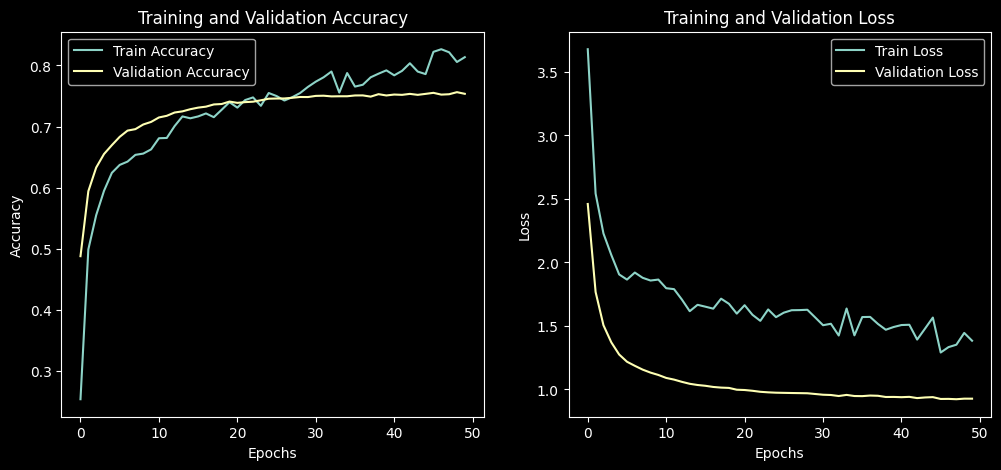

In [6]:
import matplotlib.pyplot as plt
plt.style.use('dark_background')

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.show()

In [ ]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import (
    classification_report,
    precision_score,
    recall_score,
    f1_score,
    precision_recall_fscore_support
)

# Evaluate the model on the test set
y_eval = model.evaluate(x_test, y_test)

# Get model predictions
y_pred_probs = model.predict(x_test)  # Get probability predictions
y_pred = np.argmax(y_pred_probs, axis=1)  # Convert to class labels

print("Evaluation metrics:", y_eval)
print("Predicted classes:", y_pred)

# Convert y_test to class labels if it is one-hot encoded.
if y_test.ndim > 1:
    y_true = np.argmax(y_test, axis=1)
else:
    y_true = y_test

# Define the CIFAR-100 fine label names (taken from website)
class_names = [
    # Aquatic mammals
    "beaver", "dolphin", "otter", "seal", "whale",
    # Fish
    "aquarium fish", "flatfish", "ray", "shark", "trout",
    # Flowers
    "orchids", "poppies", "roses", "sunflowers", "tulips",
    # Food containers
    "bottles", "bowls", "cans", "cups", "plates",
    # Fruit and vegetables
    "apples", "mushrooms", "oranges", "pears", "sweet peppers",
    # Household electrical devices
    "clock", "computer keyboard", "lamp", "telephone", "television",
    # Household furniture
    "bed", "chair", "couch", "table", "wardrobe",
    # Insects
    "bee", "beetle", "butterfly", "caterpillar", "cockroach",
    # Large carnivores
    "bear", "leopard", "lion", "tiger", "wolf",
    # Large man-made outdoor things
    "bridge", "castle", "house", "road", "skyscraper",
    # Large natural outdoor scenes
    "cloud", "forest", "mountain", "plain", "sea",
    # Large omnivores and herbivores
    "camel", "cattle", "chimpanzee", "elephant", "kangaroo",
    # Medium-sized mammals
    "fox", "porcupine", "possum", "raccoon", "skunk",
    # Non-insect invertebrates
    "crab", "lobster", "snail", "spider", "worm",
    # People
    "baby", "boy", "girl", "man", "woman",
    # Reptiles
    "crocodile", "dinosaur", "lizard", "snake", "turtle",
    # Small mammals
    "hamster", "mouse", "rabbit", "shrew", "squirrel",
    # Trees
    "maple", "oak", "palm", "pine", "willow",
    # Vehicles 1
    "bicycle", "bus", "motorcycle", "pickup truck", "train",
    # Vehicles 2
    "lawn-mower", "rocket", "streetcar", "tank", "tractor"
]

# Compute overall metrics
precision_val = precision_score(y_true, y_pred, average='macro')
recall_val = recall_score(y_true, y_pred, average='macro')
f1_val = f1_score(y_true, y_pred, average='macro')

print(f"Precision: {precision_val}")
print(f"Recall: {recall_val}")
print(f"F1 Score: {f1_val}")

# Print the full classification report with class names.
print("\nClassification Report:")
report = classification_report(y_true, y_pred, target_names=class_names)
print(report)

# Compute per-class F1 scores to find the worst performing class.
# This returns arrays for precision, recall, f1, and support for each class.
_, _, f1_scores, _ = precision_recall_fscore_support(y_true, y_pred, average=None, labels=np.arange(len(class_names)))

# Identify the class with the minimum F1 score.
worst_index = np.argmin(f1_scores)
worst_class_name = class_names[worst_index]
worst_f1 = f1_scores[worst_index]

print(f"\nWorst performing class: {worst_class_name} with F1 score: {worst_f1:.4f}")
